In [2]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from scipy.spatial import distance
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [4]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab.json/'))))

955500it [00:02, 396473.88it/s]


In [5]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [6]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [7]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.51it/s]


In [8]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [9]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [10]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [32]:
def plot_pairs(lr_df, path, w=12, h=12):

    fig, axes = plt.subplots(int(len(lr_df)/2), 2, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes.reshape(-1)[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.lineplot(x='window', y='acc', data=pdf, ax=ax, err_style='bars')
        ax.plot(fitx, fity, c='black', linewidth=1, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'({i+1}) {r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

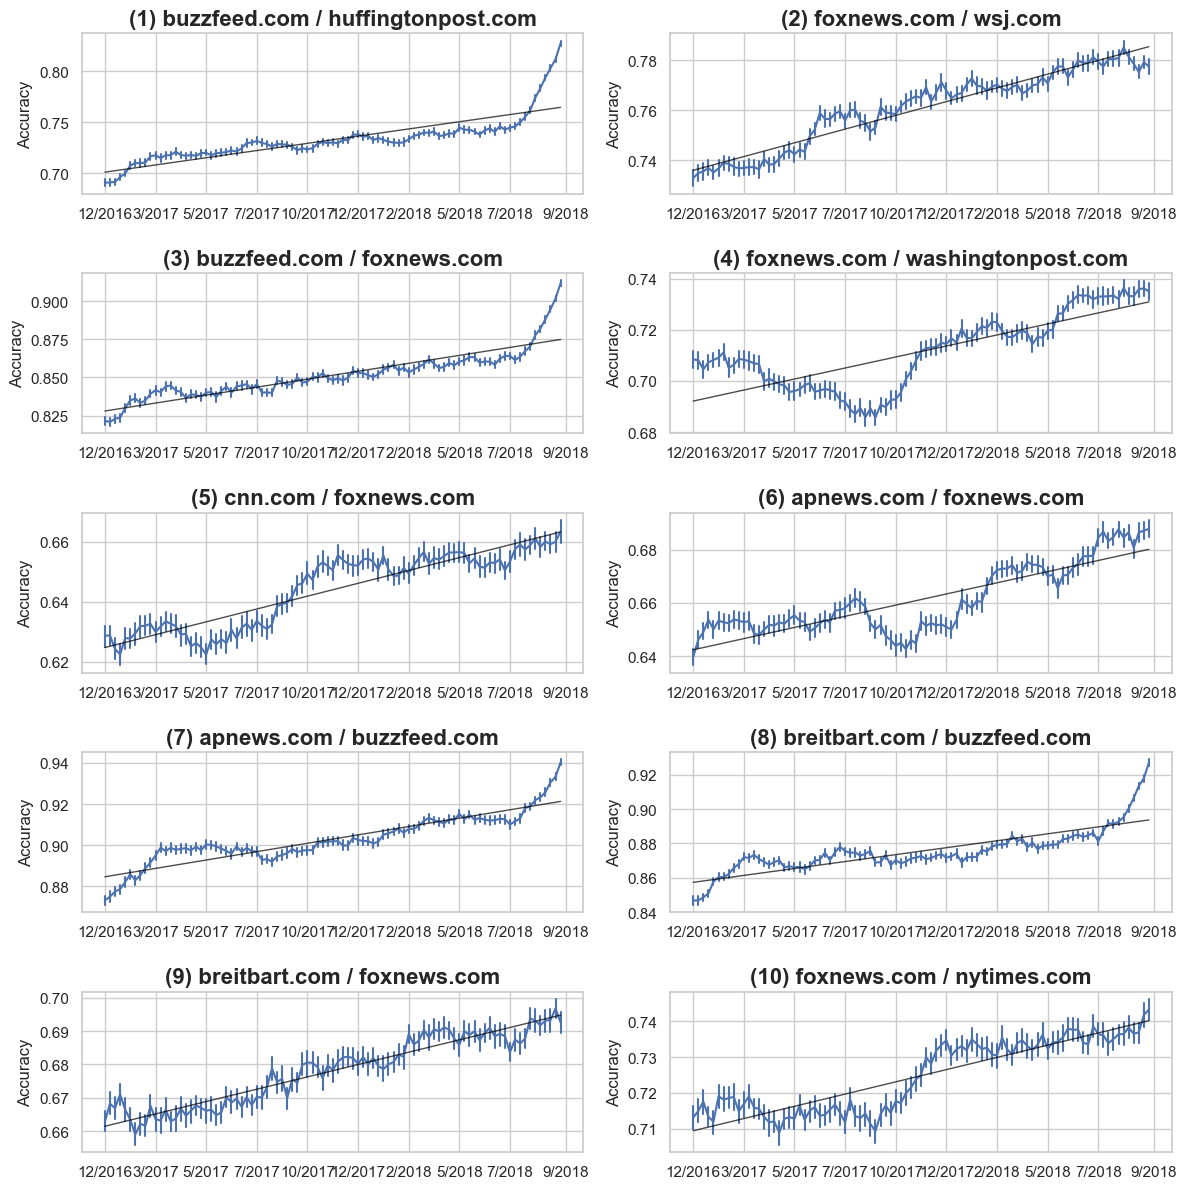

In [33]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

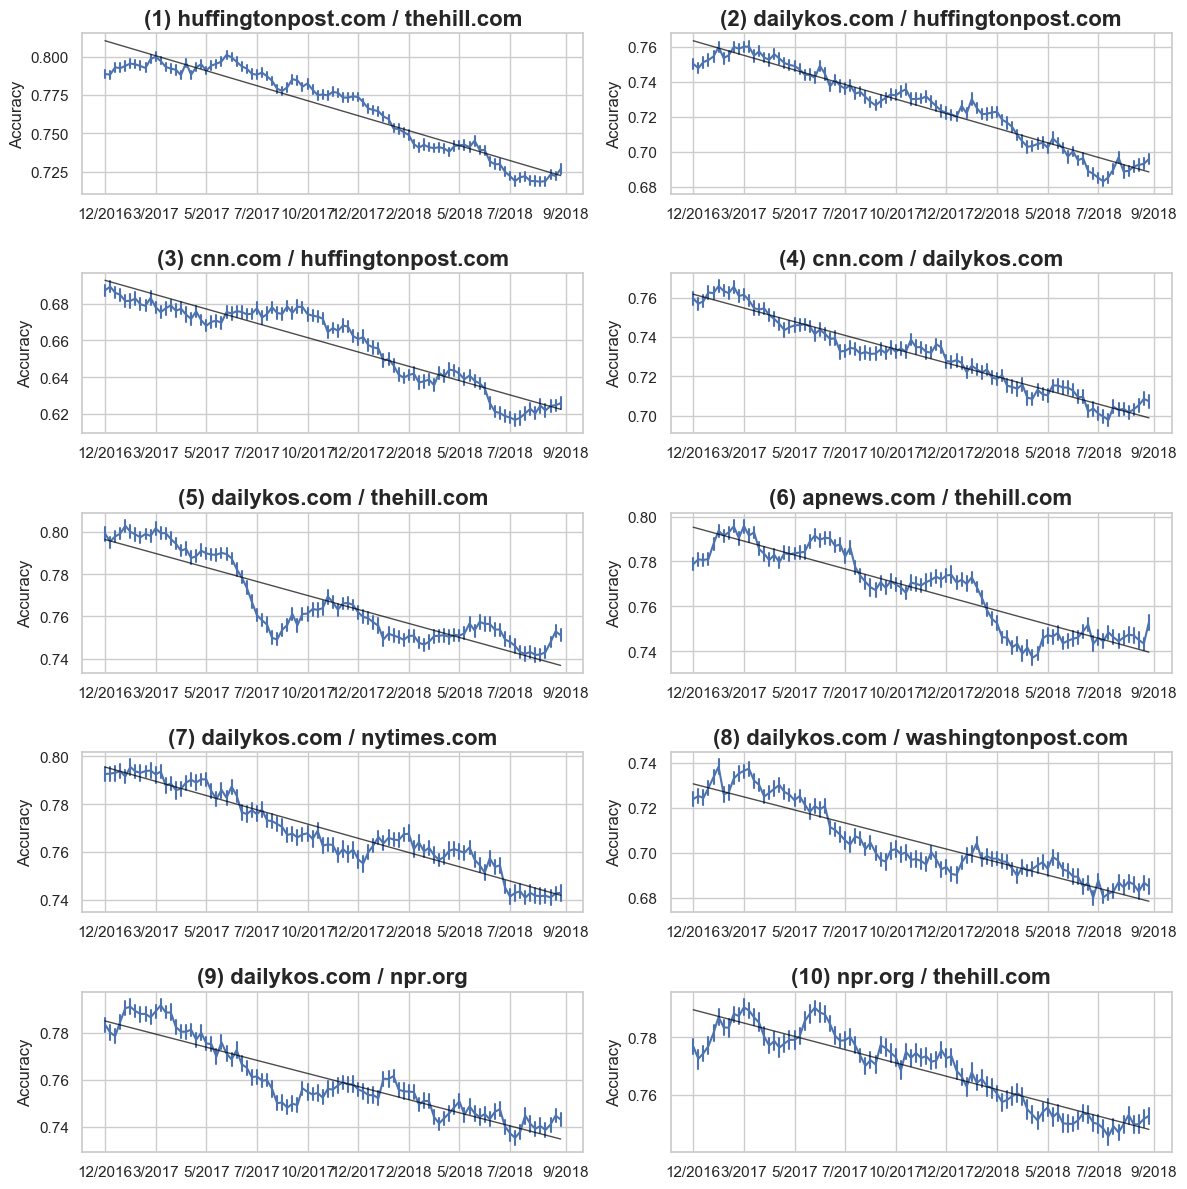

In [34]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [11]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

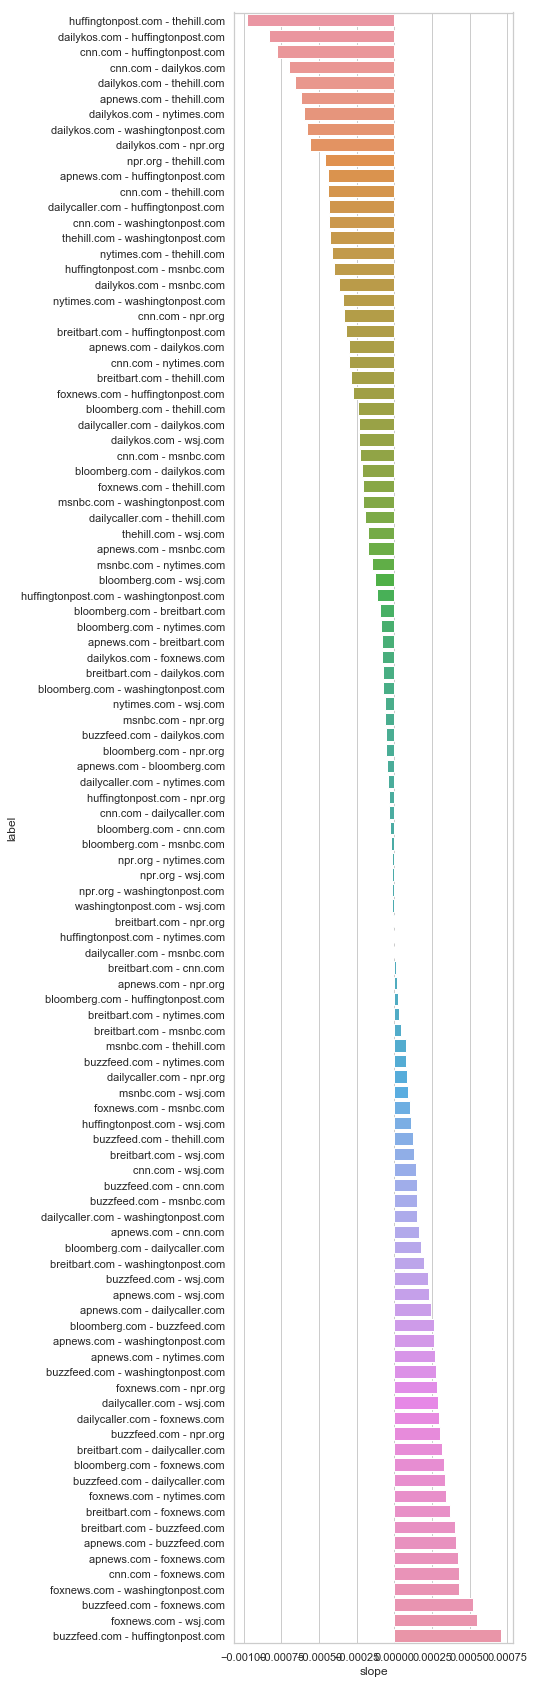

In [111]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [12]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = preprocessing.minmax_scale(abs(lr_df.slope), (0,3)) ** 2

In [13]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [14]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


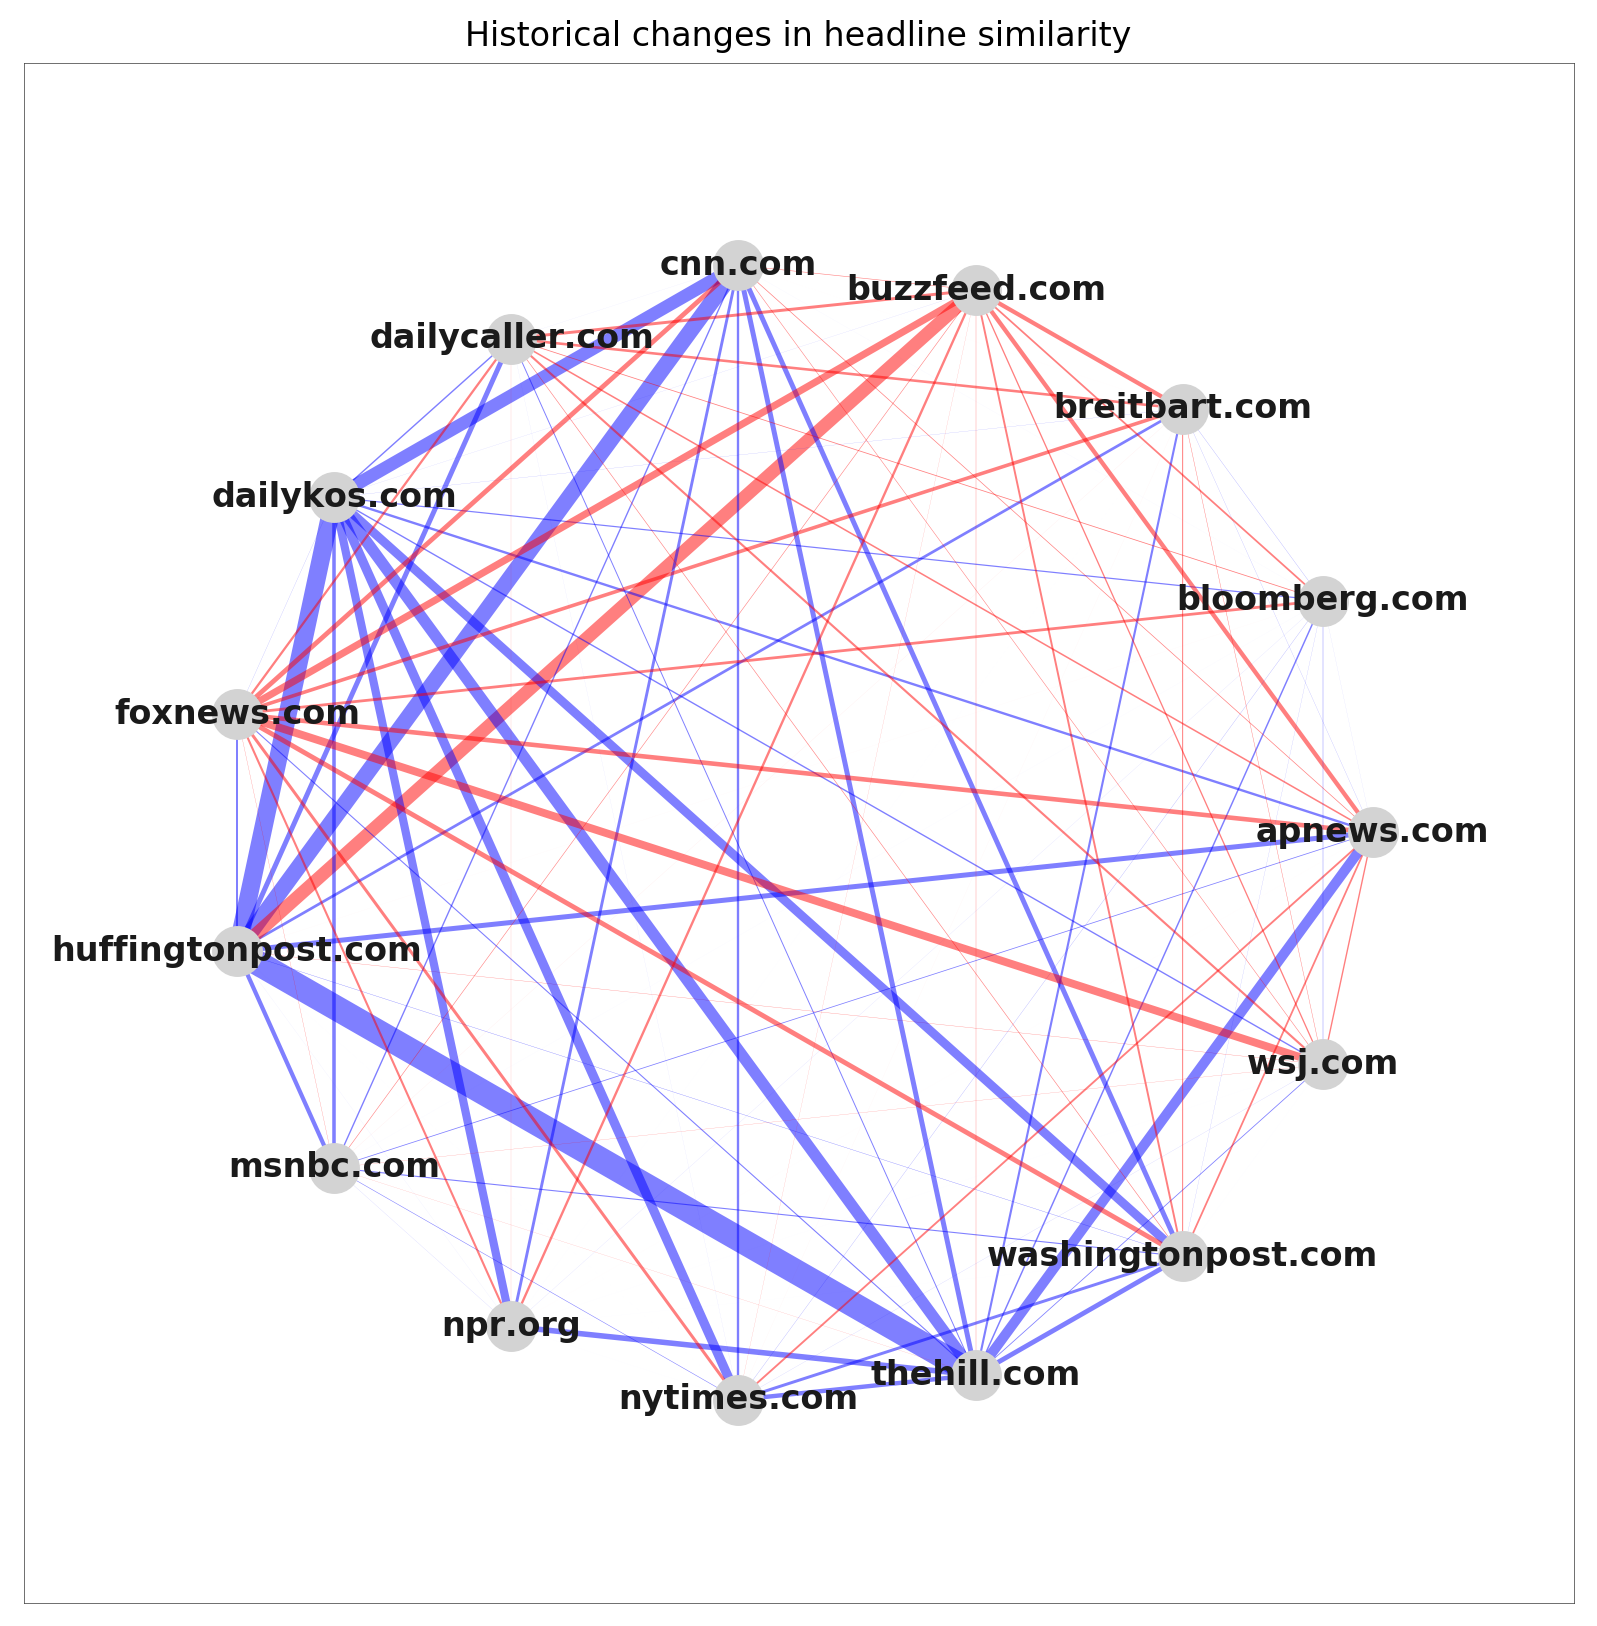

In [17]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(sorted(g.node))
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [19]:
pred_df, embeds = read_preds('../../data/ava-ts-cnn/')

100%|██████████| 361/361 [00:17<00:00, 20.99it/s]


In [23]:
len(pred_df[(pred_df.domain=='nytimes.com')&(pred_df.decile==0)])

2402

In [24]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [25]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [26]:
pred_df_start = pred_df[pred_df.decile.isin([0,1,2])]
pred_df_end = pred_df[pred_df.decile.isin([7,8,9])]

In [27]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_start.index):
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_end.index):
    idx_end.add_item(i, embeds[i])

100%|██████████| 74696/74696 [00:05<00:00, 12759.22it/s]


In [28]:
idx_start.build(20)
idx_end.build(20)

True

In [29]:
def mean_cosine_d(domain):
    
    df1 = pred_df_end[pred_df_end.domain==domain]
    df2 = pred_df_start[pred_df_start.domain==domain]
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)
    
    return distance.cosine(v1, v2)

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


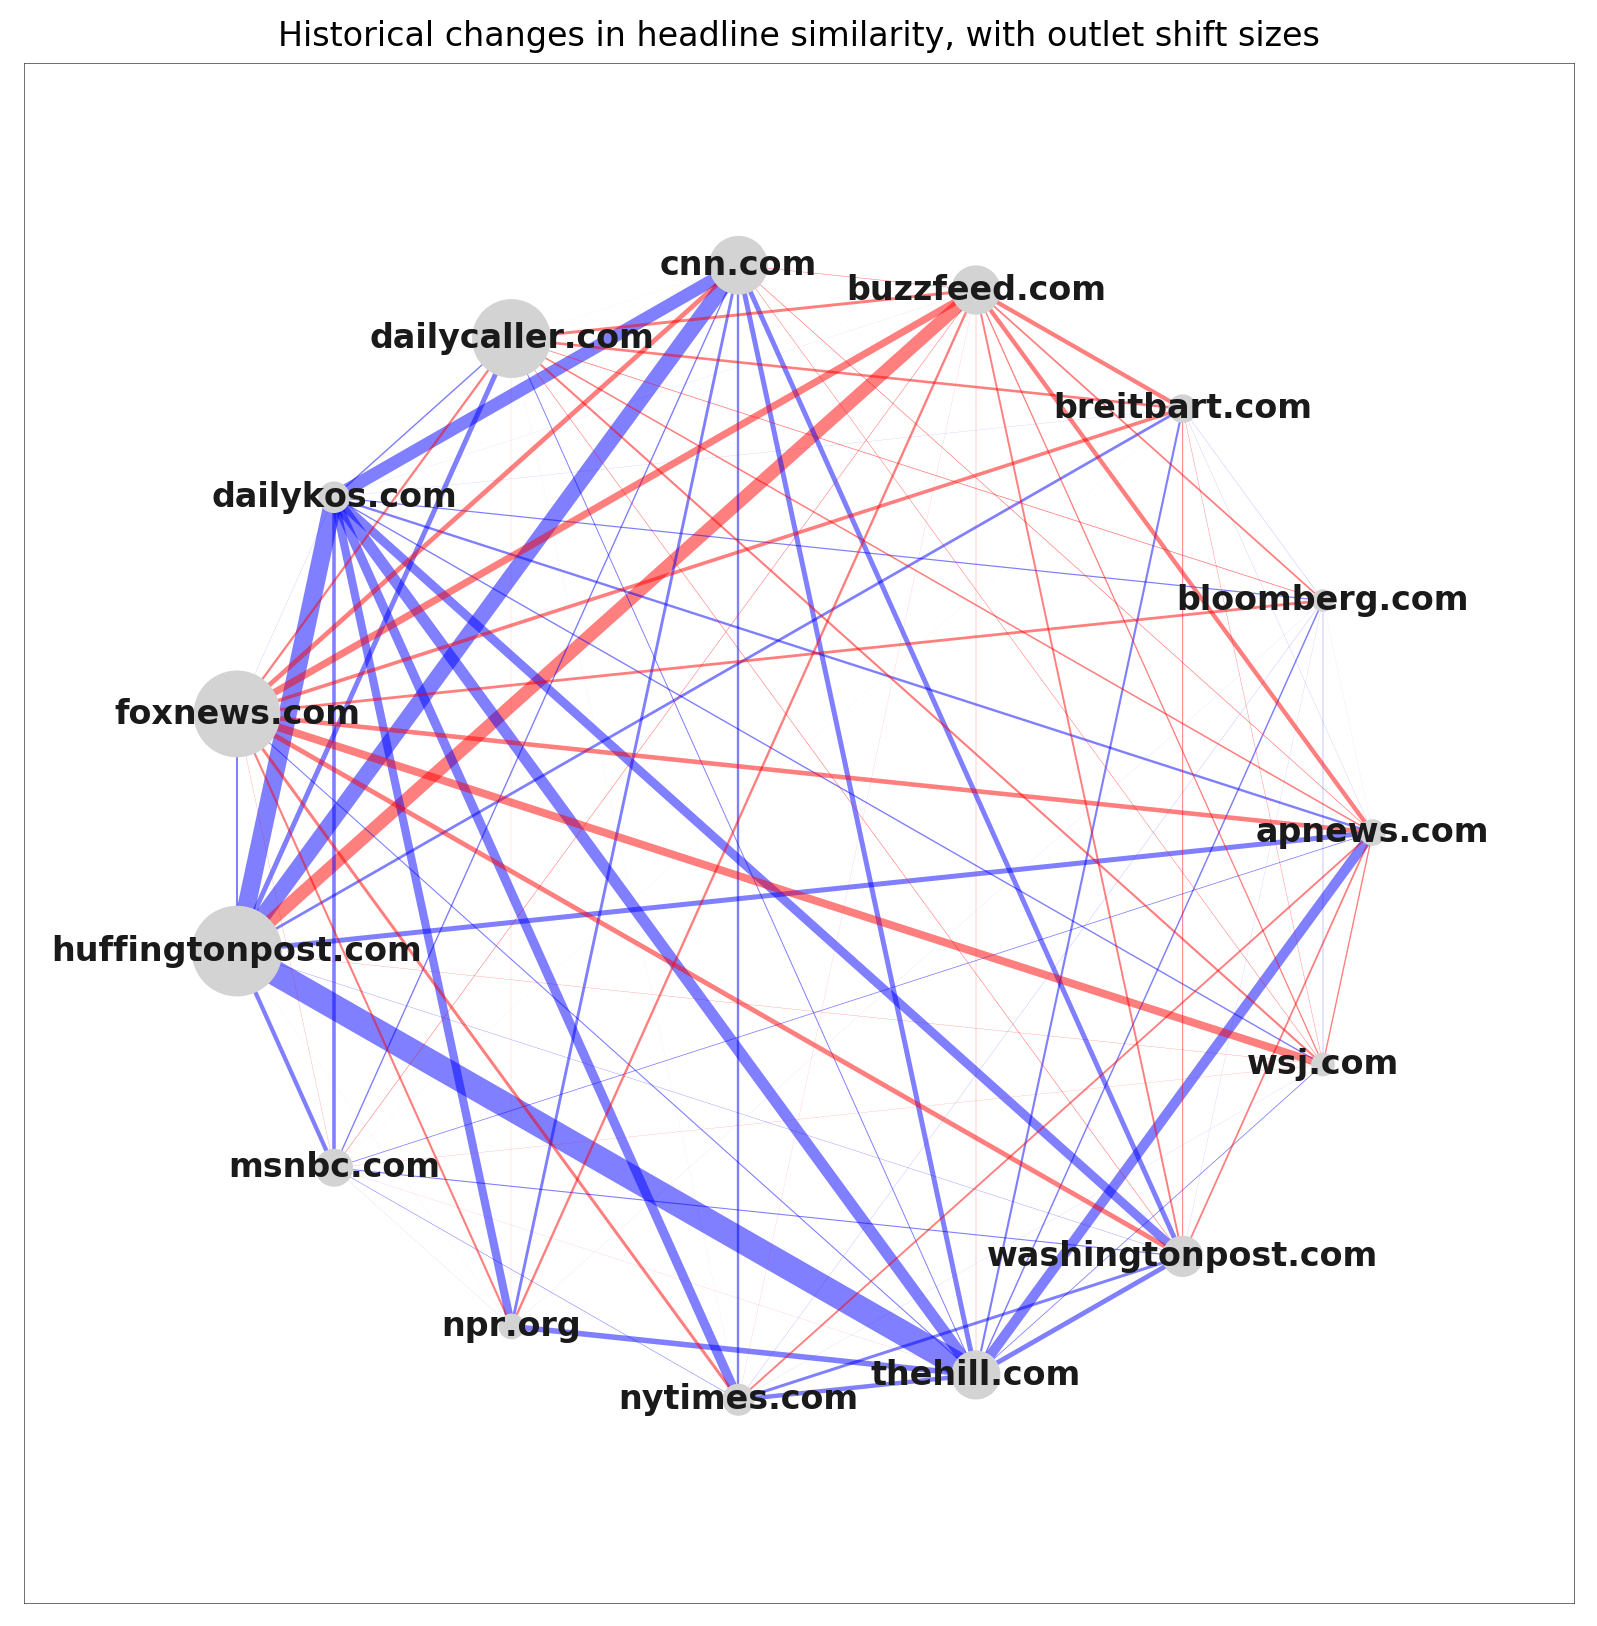

In [30]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]
node_size = preprocessing.minmax_scale([mean_cosine_d(n) for n in g.nodes], (50,1000))

mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity, with outlet shift sizes')

pos = nx.layout.circular_layout(sorted(g.node))
nx.draw_networkx_nodes(g, pos, node_color='lightgray', node_size=node_size)
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial-magnitude.png', bbox_inches='tight')

In [40]:
def delta_hls(df1, df2, idx, domain=None, n=20, probe=100000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(' '.join(r.clf_tokens))
            matches += 1
            if matches == n:
                break

In [41]:
def delta_hls_domain_start(domain):
    
    delta_hls(
        pred_df_end[pred_df_end.domain==domain],
        pred_df_start[pred_df_start.domain==domain],
        idx_start,
        domain,
    )

In [42]:
def delta_hls_domain_end(domain):
    
    delta_hls(
        pred_df_start[pred_df_start.domain==domain],
        pred_df_end[pred_df_end.domain==domain],
        idx_end,
        domain,
    )

# Buzzfeed

In [43]:
delta_hls_domain_start('buzzfeed.com')

as trump takes office birth control startups see demand spike
trump hotel contractor drops $ # million lawsuit
taiwanese court delivers landmark ruling in favour of marriage equality
trump administration punts again on obamacare subsidy lawsuit
congressmen seek to lift propaganda ban
trump picks patriot act lawyer for top state department job
us and cuba to open diplomatic relations in historic agreement
north carolina officials seek to stop special elections
obama warns inequality could derail climate change efforts
police fired gas at protesters outside trump s rally
mike pence on confederate statues i m someone who believes in more monuments not less
libyan dissident wins right to sue ex foreign secretary jack straw over rendition
clinton iowa volunteers train when to push backers to omalley to block bernie
guardian ditches move to kushner building after newsroom revolt
alex jones suffers defeat in custody hearing
bannon ally leaves white house as mcmaster consolidates power
devos f

In [44]:
delta_hls_domain_end('buzzfeed.com')

answer these five questions and we ll tell you which shrek character you are in bed
build your high school life and we ll reveal which character you are from finding nemo
take a trip to the beach and we ll tell you which summer bop you should listen to
pick a movie from each year and we ll tell you which comedy show you belong on
check off all the classic disney movies you ve seen and we ll guess how old you are
tell us your perfect night in and we ll tell you which literature lady you are
create a breakup playlist and we ll tell you which iconic movie character you were in a past life
tell us your favorite female tv character and we ll tell you what your greatest strength is
plan a movie night and we ll tell you which character from the incredibles you re most like
decorate your apartment with uo decor and we ll reveal which celebrity will live with you
plan your dream first date and we ll tell you how old your soulmate is right now
make a break up playlist and we ll tell you which ma

# HuffPo

In [45]:
delta_hls_domain_start('huffingtonpost.com')

connecting food and your mood
a tale of two globalizations
a true omnichannel experience reaps the biggest rewards
the rise of deaftalent
yes you can get bbq from a drive thru
what s your dietary footprint
the problem with tickling
how s your grammarly mine s great
the genius trick for oatmeal that ll make your mornings easier
how many people are vegetarian
the future of work is collective
a beginner s guide to digital advertising
do women really need a yearly pelvic exam
tired of mid century modern try these cozy couches instead
how to create thought leading ideas
your gut feeling fear or intuition
make your goals stick
how to make vegan parmesan cheese and make your dreams come true
how dieting makes you gain weight
how do you know if your therapist is helping you


In [46]:
delta_hls_domain_end('huffingtonpost.com')

trump honors fallen soldiers on memorial day with self congratulatory tweet
omarosa claims trump has mental decline that could not be denied
tennessee man accused of burning black man alive was known white supremacist
ambien maker denounces roseanne barr for blaming racist tweet on insomnia drug
editorial cartoonist critical of trump fired from pittsburgh newspaper
man yelling about trump opens fire in president s florida golf club
susan collins receives # coat hangers ahead of kavanaugh vote
tsa apologizes to ny giants player for spilling mom s ashes during bag search
man who refused to hand over immigrant info to ice do nt collaborate with fascists
federal prosecutor put on leave for targeting maxine waters with hateful facebook post
karl rove likens trump to stalin tells him to tone down anti press rants
tennessee pastor resigns after admitting sexual incident was abuse of power
florida dem candidate for governor relying on vocal trump supporter
country star gretchen wilson arrested

# Fox

In [47]:
delta_hls_domain_start('foxnews.com')

haier boss looks far beyond appliances
are government leaders turning a blind eye toward debt
power prices in focus as heat wave hits
china s geely to buy lotus take stake in malaysia s proton
investment fund providing financing for health care
peru s finance minister quits over audio recordings
taiwan holds war games simulating chinese island attack
india s modi discusses trade ties with turkey s erdogan
eurozone economic sentiment at near decade highs
biggest movies to look forward to in #
republicans struggle to resuscitate health bill
ancient root with modern benefits
get the fugitives back from cuba
many students voted twice in uk election
fewer fret over more focus on politics
strong winds dry forests fuel portugal fires
severe bolivian drought hurts crops threatens capital
bao bao ready for new life in china
alitalia workers vote on cuts to stave off bankruptcy
mayim bialik to register as muslim


In [48]:
delta_hls_domain_end('foxnews.com')

florida man drops meth off at sheriff s office for testing after suffering bad reaction police say
stars rally around liberal james gunn after offensive tweets unlike reaction to trump supporting roseanne barr
professor banned from restaurant for profanity laced rant against white children university investigating
washington state store clerk left to die by teen robbers after suffering heart attack cops say
nbc news president noah oppenheim killed ronan farrow s harvey weinstein expose to protect his hollywood ambitions report says
florida school resource officer slams unruly student to ground do nt give me your sh
new jersey cops used sex toy big blue to harass co workers played game with genitals lawsuit says
cheryl slams nasty false liam payne breakup reports says her mom has absolutely nothing to do with any of it
papa john schnatter allegedly refused to work with kanye west because of n word in his lyrics
anne hathaway calls out white privilege in wake of black woman stabbed to de

# DailyKos

In [49]:
delta_hls_domain_start('dailykos.com')

is trumpcare just a way for paul ryan to achieve his true dream of destroying medicare
rep jamie raskin nails the gop s blatant healthcare hypocrisy every american should see this
the everything terrible the trump administration has done so far omnibus week #
republicans have a solution to finding the votes they need for their healthcare bill massive bribery
q poll on trumpcare backing this bill could be very hazardous to your political health
joe biden on trumpcare it s enough to make your blood boil
by reviving the trumpcare zombie tom macarthur may have lobotomized his own career
the photo of a regretful trump supporter is going viral on donald s own playground twitter
promises promises donald trump s made them and trumpcare will break them
the fight continues daily kos proudly endorses three great democrats to resist the trump agenda
how incompetent is paul ryan the house might have to revote on zombie trumpcare
this is not normal republican senators in the dark on trumpcare bill t

In [50]:
delta_hls_domain_end('dailykos.com')

teachers flee success high school
freed from death row sabrina butler smith s story
uk identifies russians who made nerve agent attack on skripals
selling fossils lizard origins probiotic flies
north korea snubs united states on talks over returning war dead
retired teacher sentenced to # # months in case brought by energy transfer partners
for starters bernie say his name
individuals can change world mumbai man drives beach clean ups species return
stone age cow surgery high carbon grasses ocean churning shrimp
investing in early childhood education means big long term gains
opt out of high stakes testing begins this week
bad news hodgkin s has returned
wells fargo blames computer glitch for hundreds of customers lost homes
purported drone footage of texas tent city for separated children released by bbc
amazon delivery drivers report wage theft and other abuses
criminal charges in manhattan wage theft and insurance fraud case
november coming into focus
it came from outer space
but he